# FL
* Fish lake Small Domain
## Statistics with Subsampled Dataset 

Created new env: From *rasterio*, a copy of that to install rioxarray, now *rasterio_copy*

In [2]:
# import packages 
# %matplotlib inline #have to remote this to get rid of the scikit-gstat warning with plotting... 

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
# import rasterstats

In [3]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [12,6] #overriding size

In [4]:
!conda env list

# conda environments:
#
base                     C:\Users\Lumbr\miniconda3
raster                   C:\Users\Lumbr\miniconda3\envs\raster
rasterio                 C:\Users\Lumbr\miniconda3\envs\rasterio
rasterio_copy         *  C:\Users\Lumbr\miniconda3\envs\rasterio_copy
unload                   C:\Users\Lumbr\miniconda3\envs\unload



In [5]:
# labels and cosntants 
# titles
fl_title = 'Fish Lake Small Domain'

# labels 
dce_label = 'distance to canopy edge (m)'
dah_label = 'diurnal anisotropic heat index'
slope_label = 'slope (degrees)'
aspect_label = 'aspect (degrees)'
snow_label = 'snow depth (m)'

dceclassdict = {1: 'Large Clusters', 2: 'Small Clusters', 3: 'Edges', 4: 'Small Gaps', 5: 'Large Gaps'}

In [24]:
ds = xr.open_dataset('/Users/Lumbr/OneDrive - UW/Documents/Washington/EasternCascades/Python/Output/fl_smalldomain_create_netcdf.nc')
ds

<xarray.Dataset>
Dimensions:                         (x: 3725, y: 3330, band: 1)
Coordinates:
  * x                               (x) float64 1.492e+06 ... 1.503e+06
  * y                               (y) float64 8.058e+05 ... 7.958e+05
  * band                            (band) int32 1
Data variables: (12/29)
    snowdepth                       (band, y, x) float32 ...
    dce                             (band, y, x) float32 ...
    dem                             (band, y, x) float32 ...
    dah                             (band, y, x) float32 ...
    dah_reclass                     (band, y, x) float32 ...
    dce_reclass                     (band, y, x) float32 ...
    ...                              ...
    canopyedges_negdah_snowdepth    (band, y, x) float32 ...
    smallgaps_posdah_snowdepth      (band, y, x) float32 ...
    smallgaps_negdah_snowdepth      (band, y, x) float32 ...
    largegaps_posdah_snowdepth      (band, y, x) float32 ...
    largegaps_negdah_snowdepth      (band, y, x) float32 ...
    spatial_ref                     int32 ...

In [25]:
# flatten everything to save time later
dce_flat=ds.dce.values.flatten()
dce_reclass_flat=ds.dce_reclass.values.flatten()

dah_flat=ds.dah.values.flatten()
dah_reclass_flat=ds.dah_reclass.values.flatten()

snowdepth_flat=ds.snowdepth.values.flatten()
dem_flat = ds.dem.values.flatten()
# slope_flat=ds.slope.values.flatten()
# aspect_flat=ds.aspect.values.flatten()

dce_dahpos_reclass_flat=ds.dce_dahpos_reclass.values.flatten()
dce_dahneg_reclass_flat=ds.dce_dahneg_reclass.values.flatten()

In [26]:
# Make groups for dce classifications
# setting to larger values outside of distance ranges to avoid overwriting 
largeclusters = ds.where(ds.dce_reclass == 100)
smallclusters = ds.where(ds.dce_reclass == 200)
canopyedges   = ds.where(ds.dce_reclass == 300)
smallgaps     = ds.where(ds.dce_reclass == 400)
largegaps     = ds.where(ds.dce_reclass == 500)

# Make groups for dah classification 
dahpos = ds.where(ds.dce_reclass ==  1)
dahneg = ds.where(ds.dce_reclass == -1)

# Flatten and remove nans -----------------------------------------------------------------------
# dce
largeclusters_flat = largeclusters.snowdepth.values.flatten()
smallclusters_flat = smallclusters.snowdepth.values.flatten()
canopyedges_flat   = canopyedges.snowdepth.values.flatten()
smallgaps_flat     = smallgaps.snowdepth.values.flatten()
largegaps_flat     = largegaps.snowdepth.values.flatten()

largeclusters_flat = largeclusters_flat[~(np.isnan(largeclusters_flat))] # removing the nans 
smallclusters_flat = smallclusters_flat[~(np.isnan(smallclusters_flat))]
canopyedges_flat   = canopyedges_flat[~(np.isnan(canopyedges_flat))]
smallgaps_flat     = smallgaps_flat[~(np.isnan(smallgaps_flat))]
largegaps_flat     = largegaps_flat[~(np.isnan(largegaps_flat))]

# dah
dahpos_flat     = dahpos.snowdepth.values.flatten()
dahpos_flat     = dahpos_flat[~(np.isnan(dahpos_flat))]

dahneg_flat     = dahneg.snowdepth.values.flatten()
dahneg_flat     = dahneg_flat[~(np.isnan(dahneg_flat))]



# For pos vs neg groups -----------------------------------------------------------------------
# first set the values for each of the two pos and neg datasets 
largeclusters_dahpos = ds.where(ds.dce_dahpos_reclass == 100)
smallclusters_dahpos = ds.where(ds.dce_dahpos_reclass == 200)
canopyedges_dahpos   = ds.where(ds.dce_dahpos_reclass == 300)
smallgaps_dahpos     = ds.where(ds.dce_dahpos_reclass == 400)
largegaps_dahpos     = ds.where(ds.dce_dahpos_reclass == 500)

largeclusters_dahneg = ds.where(ds.dce_dahneg_reclass == 100)
smallclusters_dahneg = ds.where(ds.dce_dahneg_reclass == 200)
canopyedges_dahneg   = ds.where(ds.dce_dahneg_reclass == 300)
smallgaps_dahneg     = ds.where(ds.dce_dahneg_reclass == 400)
largegaps_dahneg     = ds.where(ds.dce_dahneg_reclass == 500)


# For pos vs neg groups 
# dce pos dah
largeclusters_dahpos_flat = largeclusters_dahpos.snowdepth.values.flatten()
smallclusters_dahpos_flat = smallclusters_dahpos.snowdepth.values.flatten()
canopyedges_dahpos_flat   = canopyedges_dahpos.snowdepth.values.flatten()
smallgaps_dahpos_flat     = smallgaps_dahpos.snowdepth.values.flatten()
largegaps_dahpos_flat     = largegaps_dahpos.snowdepth.values.flatten()

largeclusters_dahpos_flat = largeclusters_dahpos_flat[~(np.isnan(largeclusters_dahpos_flat))] # removing the nans 
smallclusters_dahpos_flat = smallclusters_dahpos_flat[~(np.isnan(smallclusters_dahpos_flat))]
canopyedges_dahpos_flat   = canopyedges_dahpos_flat[~(np.isnan(canopyedges_dahpos_flat))]
smallgaps_dahpos_flat     = smallgaps_dahpos_flat[~(np.isnan(smallgaps_dahpos_flat))]
largegaps_dahpos_flat     = largegaps_dahpos_flat[~(np.isnan(largegaps_dahpos_flat))]

# dce neg dah
largeclusters_dahneg_flat = largeclusters_dahneg.snowdepth.values.flatten()
smallclusters_dahneg_flat = smallclusters_dahneg.snowdepth.values.flatten()
canopyedges_dahneg_flat   = canopyedges_dahneg.snowdepth.values.flatten()
smallgaps_dahneg_flat     = smallgaps_dahneg.snowdepth.values.flatten()
largegaps_dahneg_flat     = largegaps_dahneg.snowdepth.values.flatten()

largeclusters_dahneg_flat = largeclusters_dahneg_flat[~(np.isnan(largeclusters_dahneg_flat))] # removing the nans 
smallclusters_dahneg_flat = smallclusters_dahneg_flat[~(np.isnan(smallclusters_dahneg_flat))]
canopyedges_dahneg_flat   = canopyedges_dahneg_flat[~(np.isnan(canopyedges_dahneg_flat))]
smallgaps_dahneg_flat     = smallgaps_dahneg_flat[~(np.isnan(smallgaps_dahneg_flat))]
largegaps_dahneg_flat     = largegaps_dahneg_flat[~(np.isnan(largegaps_dahneg_flat))]

## Subsampled Dataset

In [27]:
# and if you want to subsample those values, then run this cell

num = 3 # number to sample (step) at... every other.. every 5, 10 etc.

largeclusters_dahpos_flat = largeclusters_dahpos_flat[::num] #start:stop:step
smallclusters_dahpos_flat = smallclusters_dahpos_flat[::num] 
canopyedges_dahpos_flat   = canopyedges_dahpos_flat[::num] 
smallgaps_dahpos_flat     = smallgaps_dahpos_flat[::num] 
largegaps_dahpos_flat     = largegaps_dahpos_flat[::num] 


largeclusters_dahneg_flat = largeclusters_dahneg_flat[::num] #start:stop:step
smallclusters_dahneg_flat = smallclusters_dahneg_flat[::num] 
canopyedges_dahneg_flat   = canopyedges_dahneg_flat[::num] 
smallgaps_dahneg_flat     = smallgaps_dahneg_flat[::num] 
largegaps_dahneg_flat     = largegaps_dahneg_flat[::num] 


# # create tidy subsampled df 
# df_sub = pd.DataFrame({'snowdepth': snowdepth_flat_sub,
#                    'dem': dem_flat_sub, 
#                    'dce': dce_flat_sub, 
#                    'dce_reclass': dce_reclass_flat_sub, 
#                    'dah': dah_flat_sub, 
#                    'dah_reclass': dah_reclass_flat_sub})

# # if we need to remove nans
# # df_sub.dropna(how='any', inplace=True) # it has to be everything 

# df_sub

## Box and Violin Plots

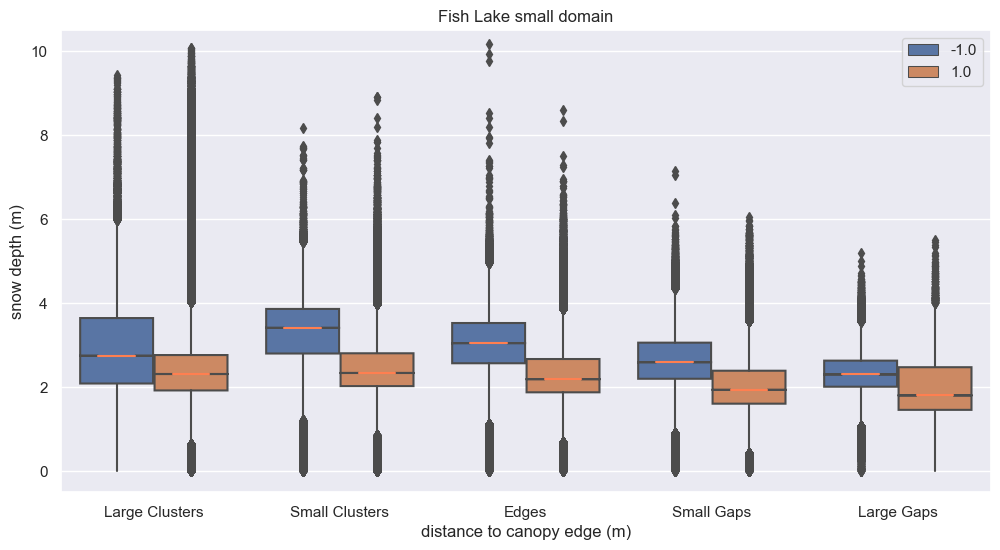

In [28]:
plt.figure(figsize=(12,6))

sns.boxplot(x=dce_reclass_flat, y=snowdepth_flat, hue=dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) # palette={1: 'orange', -1: 'blue'})
plt.xlabel(dce_label)
plt.ylabel(snow_label)
plt.title('Fish Lake small domain')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])
plt.ylim([-0.5, 10.5])

plt.show()

# Stats

## Non-parametric test for difference in the means

In [13]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Kruskal-Wallis Test
* used to determine whether or not there is a statistically significant differences between the medians of three or more independent groups 
* is considered the non-parametric equivalent of One-Way ANOVA 
https://www.statology.org/kruskal-wallis-test-python/

In [29]:
# trying Kruskal-Wallis Test, between only the dce groups
stats.kruskal(largeclusters_flat, smallclusters_flat, canopyedges_flat, smallgaps_flat, largegaps_flat)

KruskalResult(statistic=495193.93379364285, pvalue=0.0)

In [14]:
# trying Kruskal-Wallis Test, between each dce group individually 
stats.kruskal(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
stats.kruskal(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
stats.kruskal(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
stats.kruskal(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
stats.kruskal(largegaps_dahpos_flat, largegaps_dahneg_flat) 

KruskalResult(statistic=10274.505201546732, pvalue=0.0)

In [15]:
# trying Kruskal-Wallis Test, between all dah pos groups
stats.kruskal(largeclusters_dahpos_flat, smallclusters_dahpos_flat, canopyedges_dahpos_flat, smallgaps_dahpos_flat, largegaps_dahpos_flat)

KruskalResult(statistic=25108.023418095447, pvalue=0.0)

In [16]:
# trying Kruskal-Wallis Test, between all dah neg groups
stats.kruskal(largeclusters_dahneg_flat, smallclusters_dahneg_flat, canopyedges_dahneg_flat, smallgaps_dahneg_flat, largegaps_dahneg_flat)

KruskalResult(statistic=42374.56839731968, pvalue=0.0)

### Non-parametric Multiple Comparisons Following the Kruskal-Wallis Test
* interested in which groups differ from others 
From the USGS Textbook Chapter 7 Page 209 

"A conceptually simple nonparametric MCT is evaluate group patterns following a Kruskal-Wallis test is to compute all possible pairwise Wilcoxon rank-sum tests, setting the tests' error rates to achieve the family error rate, $\alpha_{family}$"

## Downsample the data 
* We are going to pick a sample size depending on the results of the variogram 
* Using the subsampled dataframe, df_sub
* We are essentially trying to reduce 'n': sample size

In [14]:
# # randomly sample from each group, 10,000

# sample_size = 500

# largeclusters_dahpos_sample = np.random.choice(largeclusters_dahpos_flat, sample_size)
# smallclusters_dahpos_sample = np.random.choice(smallclusters_dahpos_flat, sample_size)
# canopyedges_dahpos_sample   = np.random.choice(canopyedges_dahpos_flat, sample_size)
# smallgaps_dahpos_sample     = np.random.choice(smallgaps_dahpos_flat, sample_size)
# largegaps_dahpos_sample     = np.random.choice(largegaps_dahpos_flat, sample_size)

# largeclusters_dahneg_sample = np.random.choice(largeclusters_dahneg_flat, sample_size)
# smallclusters_dahneg_sample = np.random.choice(smallclusters_dahneg_flat, sample_size)
# canopyedges_dahneg_sample   = np.random.choice(canopyedges_dahneg_flat, sample_size)
# smallgaps_dahneg_sample     = np.random.choice(smallgaps_dahneg_flat, sample_size)
# largegaps_dahneg_sample     = np.random.choice(largegaps_dahneg_flat, sample_size)

### Mann-Whitney U Rank Test 
* trying to get around the issue of groups with different sizes... except we just resampled so this should not matter anymore

In [22]:
# Mann Whitney U rank test on two independent samples 
# non-parametric test to determine is the underlying distrubution of sampel x is the same as y 
stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat)

MannwhitneyuResult(statistic=351348441.5, pvalue=0.0)

In [30]:
# if each dce group is different to itself with dah neg or pos 
s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_flat, largeclusters_dahneg_flat) 
s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallclusters_dahneg_flat) 
s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_flat, canopyedges_dahneg_flat) 
s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_flat, smallgaps_dahneg_flat) 
s5, p5 = stats.mannwhitneyu(largegaps_dahpos_flat, largegaps_dahneg_flat) 

# s1, p1 = stats.mannwhitneyu(largeclusters_dahpos_sample, largeclusters_dahneg_sample) 
# s2, p2 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallclusters_dahneg_sample) 
# s3, p3 = stats.mannwhitneyu(canopyedges_dahpos_sample, canopyedges_dahneg_sample) 
# s4, p4 = stats.mannwhitneyu(smallgaps_dahpos_sample, smallgaps_dahneg_sample) 
# s5, p5 = stats.mannwhitneyu(largegaps_dahpos_sample, largegaps_dahneg_sample) 

print('For each DCE, positive vs negative DAH:')
print('large clusters pos vs neg dah, P1:', p1)
print('small clusters pos vs neg dah, P2:', p2)
print('canopy edges   pos vs neg dah, P3:', p3)
print('small gaps     pos vs neg dah, P4:', p4)
print('large gaps     pos vs neg dah, P5:', p5)

For each DCE, positive vs negative DAH:
large clusters pos vs neg dah, P1: 0.0
small clusters pos vs neg dah, P2: 0.0
canopy edges   pos vs neg dah, P3: 0.0
small gaps     pos vs neg dah, P4: 0.0
large gaps     pos vs neg dah, P5: 0.0


In [31]:
# Now, comparing only pos dah groups against all dce groups 
# For DAH pos
# for all data 
s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallclusters_dahpos_flat) 
s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_flat, canopyedges_dahpos_flat) 
s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_flat, smallgaps_dahpos_flat) 
s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_flat, largegaps_dahpos_flat) 

s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_flat, canopyedges_dahpos_flat) 
s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_flat, smallgaps_dahpos_flat) 
s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_flat, largegaps_dahpos_flat) 

s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_flat, smallgaps_dahpos_flat) 
s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_flat, largegaps_dahpos_flat) 

s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_flat, largegaps_dahpos_flat) 

# random sample
# s6, p6 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallclusters_dahpos_sample) 
# s7, p7 = stats.mannwhitneyu(largeclusters_dahpos_sample, canopyedges_dahpos_sample) 
# s8, p8 = stats.mannwhitneyu(largeclusters_dahpos_sample, smallgaps_dahpos_sample) 
# s9, p9 = stats.mannwhitneyu(largeclusters_dahpos_sample, largegaps_dahpos_sample) 

# s10, p10 = stats.mannwhitneyu(smallclusters_dahpos_sample, canopyedges_dahpos_sample) 
# s11, p11 = stats.mannwhitneyu(smallclusters_dahpos_sample, smallgaps_dahpos_sample) 
# s12, p12 = stats.mannwhitneyu(smallclusters_dahpos_sample, largegaps_dahpos_sample) 

# s13, p13 = stats.mannwhitneyu(canopyedges_dahpos_sample, smallgaps_dahpos_sample) 
# s14, p14 = stats.mannwhitneyu(canopyedges_dahpos_sample, largegaps_dahpos_sample) 

# s15, p15 = stats.mannwhitneyu(smallgaps_dahpos_sample, largegaps_dahpos_sample)

print('Positive DAH: ')
print('pos dah, large clusters vs small clusters, P6:', p6)
print('pos dah, large clusters vs canopy edges,   P7:', p7)
print('pos dah, large clusters vs small gaps,     P8:', p8)
print('pos dah, large clusters vs large gaps,     P9:', p9)
print('')
print('pos dah, small clusters vs canopy edges,  P10:', p10)
print('pos dah, small clusters vs small gaps,    P11:', p11)
print('pos dah, small clusters vs large gaps,    P12:', p12)
print('')
print('pos dah, canopy edges vs small gaps,      P13:', p13)
print('pos dah, canopy edges vs large gaps,      P14:', p14)
print('pos dah, small gaps   vs large gaps,      P15:', p15)

Positive DAH: 
pos dah, large clusters vs small clusters, P6: 0.0
pos dah, large clusters vs canopy edges,   P7: 0.0
pos dah, large clusters vs small gaps,     P8: 0.0
pos dah, large clusters vs large gaps,     P9: 0.0

pos dah, small clusters vs canopy edges,  P10: 0.0
pos dah, small clusters vs small gaps,    P11: 0.0
pos dah, small clusters vs large gaps,    P12: 0.0

pos dah, canopy edges vs small gaps,      P13: 0.0
pos dah, canopy edges vs large gaps,      P14: 0.0
pos dah, small gaps   vs large gaps,      P15: 0.0


In [33]:
# Now, comparing only neg nag groups against all dce groups 
# For DAH neg
# for all data 
s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallclusters_dahneg_flat) 
s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_flat, canopyedges_dahneg_flat) 
s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_flat, smallgaps_dahneg_flat) 
s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_flat, largegaps_dahneg_flat) 

s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_flat, canopyedges_dahneg_flat) 
s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_flat, smallgaps_dahneg_flat) 
s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_flat, largegaps_dahneg_flat) 

s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_flat, smallgaps_dahneg_flat) 
s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_flat, largegaps_dahneg_flat) 

s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_flat, largegaps_dahneg_flat) 


# For DAH neg
# for a sample of the data
# s16, p16 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallclusters_dahneg_sample) 
# s17, p17 = stats.mannwhitneyu(largeclusters_dahneg_sample, canopyedges_dahneg_sample) 
# s18, p18 = stats.mannwhitneyu(largeclusters_dahneg_sample, smallgaps_dahneg_sample) 
# s19, p19 = stats.mannwhitneyu(largeclusters_dahneg_sample, largegaps_dahneg_sample) 

# s20, p20 = stats.mannwhitneyu(smallclusters_dahneg_sample, canopyedges_dahneg_sample) 
# s21, p21 = stats.mannwhitneyu(smallclusters_dahneg_sample, smallgaps_dahneg_sample) 
# s22, p22 = stats.mannwhitneyu(smallclusters_dahneg_sample, largegaps_dahneg_sample) 

# s23, p23 = stats.mannwhitneyu(canopyedges_dahneg_sample, smallgaps_dahneg_sample) 
# s24, p24 = stats.mannwhitneyu(canopyedges_dahneg_sample, largegaps_dahneg_sample) 

# s25, p25 = stats.mannwhitneyu(smallgaps_dahneg_sample, largegaps_dahneg_sample) 



print('Negative DAH: ')
print('neg dah, large clusters vs small clusters, P16:', p16)
print('neg dah, large clusters vs canopy edges,   P17:', p17)
print('neg dah, large clusters vs small gaps,     P18:', p18)
print('neg dah, large clusters vs large gaps,     P19:', p19)
print('')
print('neg dah, small clusters vs canopy edges,   P20:', p20)
print('neg dah, small clusters vs small gaps,     P21:', p21)
print('neg dah, small clusters vs large gaps,     P22:', p22)
print('')
print('neg dah, canopy edges vs small gaps,       P23:', p23)
print('neg dah, canopy edges vs large gaps,       P24:', p24)
print('neg dah, small gaps   vs large gaps,       P25:', p25)

Negative DAH: 
neg dah, large clusters vs small clusters, P16: 0.0
neg dah, large clusters vs canopy edges,   P17: 0.0
neg dah, large clusters vs small gaps,     P18: 0.0
neg dah, large clusters vs large gaps,     P19: 0.0

neg dah, small clusters vs canopy edges,   P20: 0.0
neg dah, small clusters vs small gaps,     P21: 0.0
neg dah, small clusters vs large gaps,     P22: 0.0

neg dah, canopy edges vs small gaps,       P23: 0.0
neg dah, canopy edges vs large gaps,       P24: 0.0
neg dah, small gaps   vs large gaps,       P25: 0.0


In [34]:
# Print all the resampled dataset results 
print('For each DCE, positive vs negative DAH:')
print('large clusters pos vs neg dah, P1:', p1)
print('small clusters pos vs neg dah, P2:', p2)
print('canopy edges   pos vs neg dah, P3:', p3)
print('small gaps     pos vs neg dah, P4:', p4)
print('large gaps     pos vs neg dah, P5:', p5)

print('')
print('')

print('Positive DAH: ')
print('pos dah, large clusters vs small clusters, P6:', p6)
print('pos dah, large clusters vs canopy edges,   P7:', p7)
print('pos dah, large clusters vs small gaps,     P8:', p8)
print('pos dah, large clusters vs large gaps,     P9:', p9)
print('')
print('pos dah, small clusters vs canopy edges,  P10:', p10)
print('pos dah, small clusters vs small gaps,    P11:', p11)
print('pos dah, small clusters vs large gaps,    P12:', p12)
print('')
print('pos dah, canopy edges vs small gaps,      P13:', p13)
print('pos dah, canopy edges vs large gaps,      P14:', p14)
print('pos dah, small gaps   vs large gaps,      P15:', p15)

print('')
print('')

print('Negative DAH: ')
print('neg dah, large clusters vs small clusters, P16:', p16)
print('neg dah, large clusters vs canopy edges,   P17:', p17)
print('neg dah, large clusters vs small gaps,     P18:', p18)
print('neg dah, large clusters vs large gaps,     P19:', p19)
print('')
print('neg dah, small clusters vs canopy edges,   P20:', p20)
print('neg dah, small clusters vs small gaps,     P21:', p21)
print('neg dah, small clusters vs large gaps,     P22:', p22)
print('')
print('neg dah, canopy edges vs small gaps,       P23:', p23)
print('neg dah, canopy edges vs large gaps,       P24:', p24)
print('neg dah, small gaps   vs large gaps,       P25:', p25)

For each DCE, positive vs negative DAH:
large clusters pos vs neg dah, P1: 0.0
small clusters pos vs neg dah, P2: 0.0
canopy edges   pos vs neg dah, P3: 0.0
small gaps     pos vs neg dah, P4: 0.0
large gaps     pos vs neg dah, P5: 0.0


Positive DAH: 
pos dah, large clusters vs small clusters, P6: 0.0
pos dah, large clusters vs canopy edges,   P7: 0.0
pos dah, large clusters vs small gaps,     P8: 0.0
pos dah, large clusters vs large gaps,     P9: 0.0

pos dah, small clusters vs canopy edges,  P10: 0.0
pos dah, small clusters vs small gaps,    P11: 0.0
pos dah, small clusters vs large gaps,    P12: 0.0

pos dah, canopy edges vs small gaps,      P13: 0.0
pos dah, canopy edges vs large gaps,      P14: 0.0
pos dah, small gaps   vs large gaps,      P15: 0.0


Negative DAH: 
neg dah, large clusters vs small clusters, P16: 0.0
neg dah, large clusters vs canopy edges,   P17: 0.0
neg dah, large clusters vs small gaps,     P18: 0.0
neg dah, large clusters vs large gaps,     P19: 0.0

neg dah, s